<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/code7_model_M1_fiting_cos_ko_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P0. Các thư viện phổ biến

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as KK
import math

# P1. Mô tả mô hình

Mô hình này dùng 3 số liệu quá khứ để dự báo cho cho một giá trị tương lai

Ví dụ 1 2 3 sẽ dự báo cho 4

Chạy dự báo cho trường hợp đơn giản là chuỗi liên tục 1-432

Đánh giá kết quả tốt cho số liệu giả định trước khi dùng mô hình trên cho số liệu thực

# P2. Xây dựng mô hình cho số liệu giả định

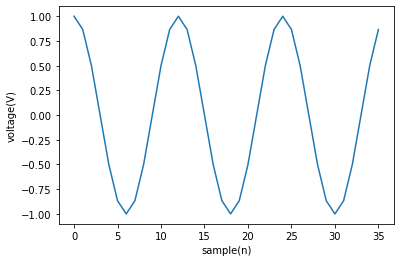

In [13]:
import matplotlib.pyplot as plt
import numpy as np


Fs = 432
f = 36
sample = 432
x = np.arange(sample)
y = np.cos(2 * np.pi * f * x / Fs)
plt.plot(x[0:36], y[0:36])
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

In [14]:
import random
y_nhieu=[]
nhieu=[]
for k in range(len(y)):
  nhieu.append(random.random())
  y_nhieu.append(y[k]+random.random())

## số liệu đầu vào

In [15]:
# dataset=np.array(range(0,432))
dataset=np.array(y_nhieu)
dataset=y
# dataset=np.array(nhieu)
vector_date=pd.date_range(start='1981-01',end='2016-12',freq='MS')
# vector_date.shape

Text(0.5, 1.0, 'testing')

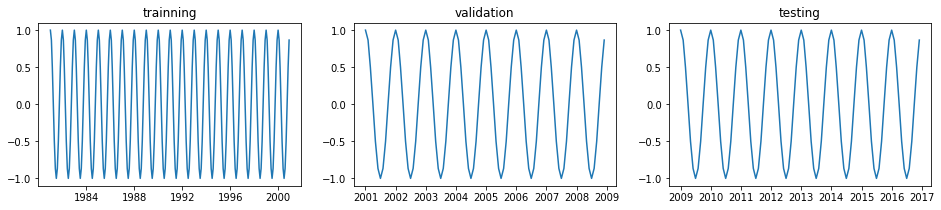

In [16]:
# plot training, validate, testing
fig,ax=plt.subplots(figsize=(16,3))
plt.subplot(131)
plt.plot(vector_date[:20*12],dataset[0:20*12])
plt.title('trainning')
plt.subplot(132)
plt.plot(vector_date[20*12:28*12],dataset[20*12:28*12])
plt.title('validation')
plt.subplot(133)
plt.plot(vector_date[28*12:],dataset[28*12:])
plt.title('testing')

## Scaled data theo trainning

In [17]:
train, validate, test=dataset[:20*12],dataset[20*12:28*12],dataset[28*12:]
# train_min, train_max,train_mean,train_std=np.min(train),np.max(train),np.mean(train),np.std(train)
# train_01,train_nor=(train-train_min)/(train_max-train_min),(train-train_mean)/train_std
# # validate scale
# validate_01,validate_nor=(validate-train_min)/(train_max-train_min),(validate-train_mean)/train_std
# # test scale
# test_01,test_nor=(test-train_min)/(train_max-train_min),(test-train_mean)/train_std

Text(0.5, 1.0, 'org')

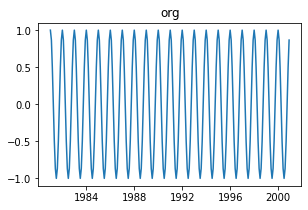

In [18]:
# plot org, min-max, normality training
fig,ax=plt.subplots(figsize=(16,3))
plt.subplot(131)
plt.plot(vector_date[:20*12],train)
plt.title('org')
# plt.subplot(132)
# plt.plot(vector_date[:20*12],train_01)
# plt.title('min-max scaled')
# plt.subplot(133)
# plt.plot(vector_date[:20*12],train_nor)
# plt.title('normality scale')

Text(0.5, 1.0, 'org')

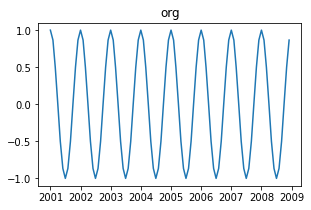

In [19]:
# plot org, min-max, normality training
fig,ax=plt.subplots(figsize=(16,3))
plt.subplot(131)
plt.plot(vector_date[20*12:28*12],validate)
plt.title('org')
# plt.subplot(132)
# plt.plot(vector_date[20*12:28*12],test_01)
# plt.title('min-max scaled')
# plt.subplot(133)
# plt.plot(vector_date[20*12:28*12],test_nor)
# plt.title('normality scale')

Giá trị scaled theo training của validate sẽ không nằm trong phạm vi 0-1, mean của validate_nor cũng không bằng 0

Không được scale trước vì toàn bộ dữ liệu testing sẽ ảnh hưởng đến quá trình training.

Nó vi phạm cái gọi là leaking data

## Chuyển dữ liệu sang dạng suppervised 3-1

In [20]:

def to_supervised(train, n_input, n_out):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[1]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end:out_end, 0])
  # move along one time step
    in_start += 1
  return np.array(X), np.array(y)

In [21]:
# chuyen train ve array 2 mang
# train_nor_2ar=train_nor.reshape(train.shape[0],1)
train_nor_2ar=train.reshape(train.shape[0],1)
n_input0,n_out0=3,1
# train_x, train_y = to_supervised(train=train_nor_2ar,n_input=n_input0,n_out=n_out0)
train_x, train_y = to_supervised(train=train_nor_2ar,n_input=n_input0,n_out=n_out0)
train_x.shape,train_y.shape

# chuyen val ve array 2 mang

# validate_nor_2ar=validate_nor.reshape(validate_nor.shape[0],1)
validate_nor_2ar=validate.reshape(validate.shape[0],1)
# n_input0,n_out0=3,1
validate_x, validate_y = to_supervised(train=validate_nor_2ar,n_input=n_input0,n_out=n_out0)
validate_x.shape,validate_y.shape

# chuyen val ve array 2 mang

# test_nor_2ar=test_nor.reshape(test_nor.shape[0],1)
test_nor_2ar=test.reshape(test.shape[0],1)
# n_input0,n_out0=3,1
test_x, test_y = to_supervised(train=test_nor_2ar,n_input=n_input0,n_out=n_out0)
test_x.shape,test_y.shape

((92, 3, 1), (92, 1))

In [22]:
# org
# train_nor[0:8]

In [23]:
# kiem tra gia 5 tri dau tien
train_x[0:5,:]

array([[[ 1.00000000e+00],
        [ 8.66025404e-01],
        [ 5.00000000e-01]],

       [[ 8.66025404e-01],
        [ 5.00000000e-01],
        [ 6.12323400e-17]],

       [[ 5.00000000e-01],
        [ 6.12323400e-17],
        [-5.00000000e-01]],

       [[ 6.12323400e-17],
        [-5.00000000e-01],
        [-8.66025404e-01]],

       [[-5.00000000e-01],
        [-8.66025404e-01],
        [-1.00000000e+00]]])

In [24]:
train_y[0:5,:]

array([[ 6.12323400e-17],
       [-5.00000000e-01],
       [-8.66025404e-01],
       [-1.00000000e+00],
       [-8.66025404e-01]])

## xây dựng các functions

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

from sklearn.metrics import mean_squared_error

# huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

In [26]:
# activate function
# Custom activation function
from keras.layers import Activation
from tensorflow.keras import backend as K
from keras.utils.generic_utils import get_custom_objects



def custom_activation(x):
    return (K.linear(x) * 1) - 0

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [27]:
# layer = tf.keras.layers.LeakyReLU()
# output = layer([-3.0, -1.0, 0.0, 2.0])
# list(output.numpy())

# layer = tf.keras.layers.LeakyReLU(alpha=0.01)
# output = layer([-3,-2,0,1, 2, 3])
# list(output.numpy())


In [28]:
## nhap cac thu vien can thiet
from keras import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping


## Cac thong so mo hinh

In [29]:
# K.clear_session()
# optimization
number_units0=300
number_epochs0=200
number_batch0=100
learing_rate0=0.001
# activation_function0='custom_activation'
# activation_function0=activations.relu
# activation_function0=activations.linear
activation_function0=activations.tanh
dropout0=0.3
patience0=20
optimizer_function0=optimizers.Adam(learing_rate0)
# loss0=tf.keras.losses.MeanAbsolutePercentageError()
loss0=tf.keras.losses.MeanSquaredError()


In [30]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# dinh nghia mô hình
KK.clear_session()
model=Sequential()
model.add(LSTM(number_units0, input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True))
model.add(LSTM(number_units0,return_sequences=True))
# model.add(LSTM(number_units0,return_sequences=True))
# model.add(LSTM(number_units0,return_sequences=True))
model.add(LSTM(number_units0))
model.add(Dropout(dropout0))
# model.add(TimeDistributed(Dense(268)))

# model.add(Dense(1,activation= activation_function0))
model.add(layers.Dense(1))
model.add(layers.Activation(activation_function0))
# tf.keras.layers.LeakyReLU(alpha=0.3) # dung leakyRelu

model.compile(loss=loss0, optimizer=optimizer_function0)
model.summary()
# callbacks_stop = [EarlyStopping(monitor='val_loss', patience=patience,min_delta=0)]
callbacks_stop = [EarlyStopping(monitor='val_loss', patience=patience0)]
# fit network using ES
history = model.fit(train_x, train_y, epochs=number_epochs0, batch_size=number_batch0, validation_data=(validate_x, validate_y),
                verbose=2, shuffle=False,callbacks=callbacks_stop)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 300)            362400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
______________________________________________

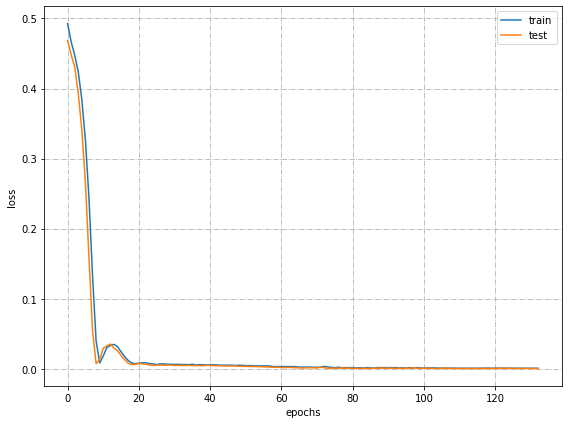

In [31]:
#  plot history
fig1=plt.Figure()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train')
ax=plt.plot(history.history['val_loss'], label='test')
plt.grid(True,linestyle='-.')
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.title("loss at "+list1[k])
plt.legend()
plt.tight_layout()
# plt.savefig(output_fig+"/"+list1[k]+str(lt)+"n_out_"+str(n_out)+"loss"+".png",dpi=300)

## Check validation

In [32]:
y_validate_hat = model.predict(validate_x)
y_validate_hat.shape
validate_y.shape
# tra lai scale ban dau
# y_validate_hat_rescaled=y_validate_hat*train_std+train_mean
# validate_y_rescaled=validate_y*train_std+train_mean

y_validate_hat_rescaled=y_validate_hat
validate_y_rescaled=validate_y

RMSE: 0.02
MAPE: 85229918708447.48%


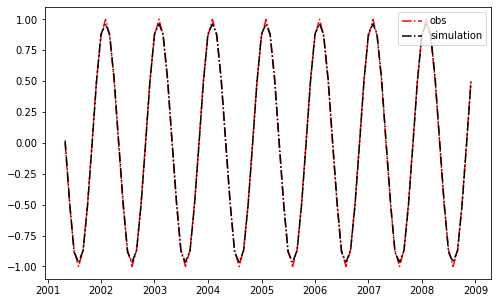

In [33]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(vector_date[20*12+n_input0+1:28*12],validate_y_rescaled,'r-.')
plt.plot(vector_date[20*12+n_input0+1:28*12],y_validate_hat_rescaled,'k-.')
plt.legend(['obs','simulation'])
# tinh sai so luon
rmse = np.sqrt(mean_squared_error(validate_y_rescaled, y_validate_hat_rescaled))
mape=mean_absolute_percentage_error(validate_y_rescaled, y_validate_hat_rescaled)

print("RMSE: " +str(round(rmse,2)))
print("MAPE: " +str(round(mape,2))+"%")

## Check testing

In [34]:
y_test_hat = model.predict(test_x)
y_test_hat.shape
test_y.shape
# tra lai scale ban dau
# y_test_hat_rescaled=y_test_hat*train_std+train_mean
# test_y_rescaled=test_y*train_std+train_mean

y_test_hat_rescaled=y_test_hat
test_y_rescaled=test_y

RMSE: 0.02
MAPE: 90345751889439.2%


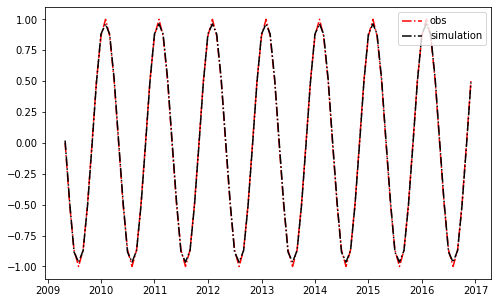

In [35]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(vector_date[28*12+n_input0+1:],test_y_rescaled,'r-.')
plt.plot(vector_date[28*12+n_input0+1:],y_test_hat_rescaled,'k-.')
plt.legend(['obs','simulation'])
# tinh sai so luon
rmse = np.sqrt(mean_squared_error(test_y_rescaled, y_test_hat_rescaled))
mape=mean_absolute_percentage_error(test_y_rescaled, y_test_hat_rescaled)

print("RMSE: " +str(round(rmse,2)))
print("MAPE: " +str(round(mape,2))+"%")